## The PennyLane QAOA Module

In [2]:
import pennylane as qml
from pennylane import qaoa
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

One of the most promising candidates for demonstrating quantum supremacy on NISQ devices is using the Quantum Approximate Optimization Algorithm (QAOA) to solve a combinatorial problem. The applications of QAOA are broad and far-reaching, and the performance of the algorithm itself is of great interest in the quantum computing research community.

The goal of this tutorial is to introduce PennyLane's built-in QAOA functionality, and in the process, highlight some of the abstract, yet powerful features that allow for the QAOA module to be intuitive and modular. 

### Defining Cost and Mixer Hamiltonians

The first step of QAOA is to define cost and mixer Hamiltonians. The optimization problem we attempt to solve is finding the *minimum vertex cover* of a graph (we refer to this problem as MinVertexCover). A vertex cover is defined as a collection of vertices within a graph, such that each edge in the graph has at least one of the vertices in the cover as an endpoint. We wish to find the vertex cover that consists of the fewest possible vertices of the graph.

PIC

The PennyLane QAOA module has a collection of built-in optimization problems, one of which is MinVertexCover. Each optimization problem is a pair of Hamiltonians, the first of which is the corresponding cost Hamiltonian, and the second of which is a reccomended mixer Hamiltonian that is known to work well. We first define the graph on which we wish to perform MinVertexCover:

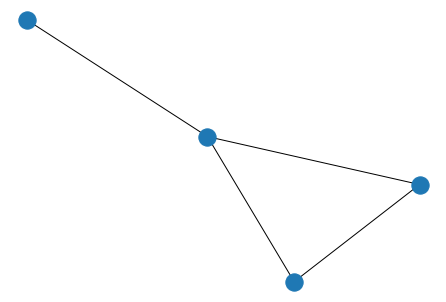

In [3]:
# Defines the graph
edges = [(0, 1), (2, 0), (1, 2), (2, 3)]
graph = nx.Graph(edges)

# Draws the graph
nx.draw(graph)
plt.show()

Then, we define the cost and mixer Hamiltonians:

In [8]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=True)

print("Cost Hamiltonian")
print(cost_h)
print("--------------------")
print("Mixer Hamiltonian")
print(mixer_h)

Cost Hamiltonian
(-1) [Z0]
+ (-1) [Z1]
+ (-1) [Z2]
+ (-1) [Z3]
--------------------
Mixer Hamiltonian
(0.25) [X0]
+ (-0.25) [X0 Z2]
+ (-0.25) [X0 Z1]
+ (0.25) [X0 Z1 Z2]
+ (0.25) [X1]
+ (-0.25) [X1 Z2]
+ (-0.25) [X1 Z0]
+ (0.25) [X1 Z0 Z2]
+ (0.125) [X2]
+ (-0.125) [X2 Z3]
+ (-0.125) [X2 Z1]
+ (0.125) [X2 Z1 Z3]
+ (-0.125) [X2 Z0]
+ (0.125) [X2 Z0 Z3]
+ (0.125) [X2 Z0 Z1]
+ (-0.125) [X2 Z0 Z1 Z3]
+ (0.5) [X3]
+ (-0.5) [X3 Z2]


### Constructing the QAOA Layers

Oftentimes, when considering quantum circuits or variational ansatzae, it is convenient to consider these processes as defined by a series of quantum gates. However, as it turns out, there are many instances where it is useful to think of a quantum circuit in terms of a *Hamiltonian*.

PIC

One of the most basic and important examples of such a circuit comes from quantum mechanics: the time-evolution operator. This unitary is defined as:

$$U(\hat{H}, \ t) \ = \ e^{-i \hat{H} t / \hbar}$$

This unitary is determined completely in terms of a Hamiltonian, $\hat{H}$ and a scalar $t$. As it turns out, any unitary $U$ can be written in the form $e^{i H}$, where $H$ is some Hamiltonian, making time-evolution the most fundamental and important example of a circuit determined by a Hamiltonian. However, in general, implementing a quantum circuit that exponentiates a Hamiltonian with many non-commuting terms:

$$H \ = \ H_1 \ + \ H_2 \ + \ H_3 \ + \ \cdots \ + \ H_N$$

is not an easy task, and involves very long strings of quantum gates. However, we are able to make use of the Trotter-Suzuki decomposition formula:

$$e^{A \ + \ B} \ \approx \ \Big(e^{A/n} e^{B/n}\Big)^{n} \ \ \ \ \ n \ \gg \ 1$$

To implement an *approximate* time-evolution unitary:

$$U_{\text{Approx}}(\hat{H}, t, n) \ = \ \displaystyle\prod_{j \ = \ 1}^{n} \displaystyle\prod_{k} e^{-i \hat{H}_k t / n} \ \ \ \ \ \ \ \ \ \ \hat{H} \ = \ \displaystyle\sum_{k} \hat{H}_k$$

where $U_{\text{Approx}}$ approaches $U$ as $n$ becomes larger. We can call this unitary with `qml.templates.ApproxTimeEvolution`. Since QAOA is essentially just time-evolution under the Hamiltonians $H_C$ and $H_M$, we can use `qml.template.ApproxTimeEvolution` to define methods `qaoa.cost_layer` and `qaoa.mixer_layer` that exponentiate cost and mixer Hamiltonians for use in QAOA:

In [9]:
# Creates a layer of the QAOA ansatz
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

PIC

### The QAOA Ansatz

With the general QAOA layer defined, we are able to build the variational ansatz. The QAOA ansatz is defined as *alternating* applications of the cost and mixer layers:

$$U_{\text{QAOA}}(\boldsymbol\gamma, \ \boldsymbol\alpha) \ = \ e^{-i \alpha_k H_M} e^{-i \gamma_k H_C} \ ... \ e^{-i \alpha_1 H_M} e^{-i \gamma_1 H_C}$$

In other words, we are repetedly applying the ``qaoa_layer`` to a set of wires. The idea of repetition is ubiquitous within quantum computing, from amplitude amplification in Grover's algorithm and HHL, to layers in quantum neural networks, to Trotterization in quantum simulation.

PIC

Due to this fact, we introduce the ``qml.layer`` function in PennyLane. This general method allows us to take a function containing quantum operations, a template, or even a single quantum gate and repeatedly apply it to a set of wires.

PIC

In the case of QAOA, this allows us to easily define the ansatz. We begin. with an even superposition over all basis states. Then, we layer ``qaoa_layer``:

In [10]:
# Defines the wires
wires = graph.nodes

depth = 2

# Defines the full QAOA circuit
def circuit(params, **kwargs):
    
    for w in wires:
        qml.PauliX(wires=w)
    
    qml.layer(qaoa_layer, depth, params[0], params[1])

Notice that ``qml.layer`` allows us to pass variational parameters ``params[0]`` and ``params[1]`` into each layer of ``qaoa_layer``.

### Optimizing the Cost Function

Now that we have defined the full QAOA ansatz, we must define and optimize the cost function. As is the case with most variational quantum algorithms, the cost function we wish to minimize is simply the expectation value of $H_C$, with respect to the state prepared by the ansatz. We can therefore use ``qml.VQECost`` to define this cost function easily. We also define the device on which simulation is performed. In this example, we will use the PennyLane-Qulacs plugin to run the simulation on the Qulacs simulator:

In [11]:
# Defines the device
dev = qml.device('qulacs.simulator', wires=wires)

# Defines the cost function
cost_function = qml.VQECost(circuit, cost_h, dev)

Finally, we optimize the cost function using the built-in ``qml.GradientDescentOptimizer``:

In [12]:
# Defines the optimizer, steps, and initial parameters
optimizer = qml.GradientDescentOptimizer()
steps = 40
params = [
    [np.random.randint(-100, 100)/100 for i in range(depth)],
    [np.random.randint(-100, 100)/100 for i in range(depth)]
]

# Optimizes the cost function
for i in range(steps):
    params = optimizer.step(cost_function, params)
    print("Step {} / {}".format(i+1, steps))

# Prints the optimal parameters
print("Optimal Parameters: {}".format(params))

Step 1 / 40
Step 2 / 40
Step 3 / 40
Step 4 / 40
Step 5 / 40
Step 6 / 40
Step 7 / 40
Step 8 / 40
Step 9 / 40
Step 10 / 40
Step 11 / 40
Step 12 / 40
Step 13 / 40
Step 14 / 40
Step 15 / 40
Step 16 / 40
Step 17 / 40
Step 18 / 40
Step 19 / 40
Step 20 / 40
Step 21 / 40
Step 22 / 40
Step 23 / 40
Step 24 / 40
Step 25 / 40
Step 26 / 40
Step 27 / 40
Step 28 / 40
Step 29 / 40
Step 30 / 40
Step 31 / 40
Step 32 / 40
Step 33 / 40
Step 34 / 40
Step 35 / 40
Step 36 / 40
Step 37 / 40
Step 38 / 40
Step 39 / 40
Step 40 / 40
Optimal Parameters: [[0.8599999999999999, -0.3449122565424062], [0.10636982351706038, 1.2816354942132282]]


With the optimal parameters, we can now reconstruct the probability landscape, to make sure that the simulation worked. We re-define the full QAOA circuit (with the optimal parameters), but this time, we return the probabilities of measuring each bitstring:

In [13]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

Finally, we can display a bar graph demonstrating the probability of measuring each bitstring:

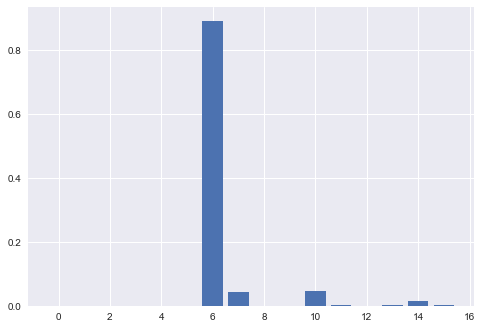

In [14]:
plt.style.use('seaborn')
plt.bar(range(2**len(wires)), probs)
plt.show()

As can be seen from this graph, the states $|10\rangle \ = \ |1010\rangle$ and $|6\rangle \ = \ |0110\rangle$ have the highest probabilities of being measured. Both of these bitstrings represent the minimum vertex covers of our graph:

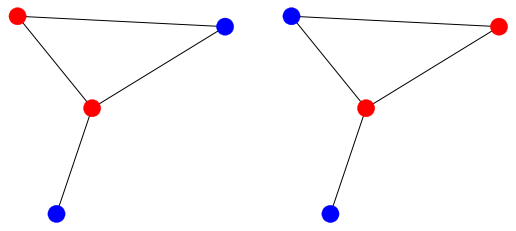

In [15]:
pos = nx.spring_layout(graph)

plt.figure(figsize=(9, 4))
plt.subplot(121)
nx.draw(graph, pos, node_color=['r', 'b', 'r', 'b'])
plt.subplot(122)
nx.draw(graph, pos, node_color=['b', 'r', 'r', 'b'])
plt.show()

In [19]:
# We then have to reward the edge 00 between nodes 0 and 4

new_cost_h = cost_h + qaoa.edge_driver(nx.Graph([(0, 3)]), ['00'])
print(new_cost_h)

(1.25) [Z0 Z1]
+ (1.25) [Z0]
+ (1.5) [Z1]
+ (1.25) [Z0 Z2]
+ (2.75) [Z2]
+ (1.25) [Z1 Z2]
+ (1.25) [Z2 Z3]
+ (-0.25) [Z0 Z3]


In [20]:
# Creates a layer of the QAOA ansatz
def new_qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, new_cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

# Creates the new circuit
def circuit(params, **kwargs):
    
    for w in wires:
        qml.PauliX(wires=w)
    
    qml.layer(new_qaoa_layer, depth, params[0], params[1])

# Optimizes the circuit

cost_function = qml.VQECost(circuit, cost_h, dev)

# Defines the optimizer, steps, and initial parameters
optimizer = qml.GradientDescentOptimizer()
steps = 40
params = [
    [np.random.randint(-100, 100)/100 for i in range(depth)],
    [np.random.randint(-100, 100)/100 for i in range(depth)]
]

# Optimizes the cost function
for i in range(steps):
    params = optimizer.step(cost_function, params)
    print("Step {} / {}".format(i+1, steps))

# Prints the optimal parameters
print("Optimal Parameters: {}".format(params))

Step 1 / 40
Step 2 / 40
Step 3 / 40
Step 4 / 40
Step 5 / 40
Step 6 / 40
Step 7 / 40
Step 8 / 40
Step 9 / 40
Step 10 / 40
Step 11 / 40
Step 12 / 40
Step 13 / 40
Step 14 / 40
Step 15 / 40
Step 16 / 40
Step 17 / 40
Step 18 / 40
Step 19 / 40
Step 20 / 40
Step 21 / 40
Step 22 / 40
Step 23 / 40
Step 24 / 40
Step 25 / 40
Step 26 / 40
Step 27 / 40
Step 28 / 40
Step 29 / 40
Step 30 / 40
Step 31 / 40
Step 32 / 40
Step 33 / 40
Step 34 / 40
Step 35 / 40
Step 36 / 40
Step 37 / 40
Step 38 / 40
Step 39 / 40
Step 40 / 40
Optimal Parameters: [[0.19999999999999998, 0.001085076222376237], [-1.100117692789273, 0.6364828283190025]]


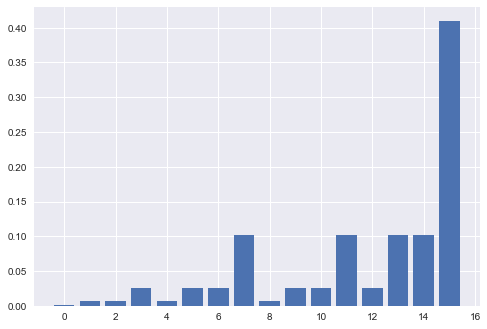

In [21]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

plt.style.use('seaborn')
plt.bar(range(2**len(wires)), probs)
plt.show()